# EXP 1

In [1]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [2]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

# FMNIST

In [3]:
NUM_EPOCHS = 10
batch_size = 64
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_set = datasets.FashionMNIST('../data', train=True, transform=trans, download=True)
test_set = datasets.FashionMNIST('../data', train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=True)

In [6]:
from torchvision import models
from torchsummary import summary

class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.bn  = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

summary(model, input_size = torch.Size([1, 28, 28]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
       BatchNorm2d-2           [-1, 32, 12, 12]              64
            Conv2d-3             [-1, 64, 8, 8]          51,264
            Linear-4                  [-1, 500]         512,500
            Linear-5                   [-1, 10]           5,010
Total params: 569,670
Trainable params: 569,670
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 2.17
Estimated Total Size (MB): 2.39
----------------------------------------------------------------


### 1. Real Net

In [13]:
class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.bn  = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.315676	Accuracy: 6.25%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.409841	Accuracy: 67.56%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.346875	Accuracy: 74.31%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.396097	Accuracy: 77.75%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.371347	Accuracy: 79.56%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.318651	Accuracy: 80.86%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.323610	Accuracy: 81.82%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.451838	Accuracy: 82.55%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.514816	Accuracy: 83.15%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.168160	Accuracy: 83.69%
Epoch 0 - Time: 30.00s - Train Loss: 0.444738 - Train Accuracy: 83.86%
Test Loss: 0.327203 - Test Accuracy: 88.00%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.286846	Accuracy: 90.62%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.317968	Accuracy: 89.23%
Train Epoch:   1 [ 12

### 2. Complex Net

In [15]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 32, 5, 1)
        self.bn  = ComplexBatchNorm2d(32)
        self.conv2 = ComplexConv2d(32, 64, 5, 1)
        self.fc1 = ComplexLinear(4*4*64, 500)
        self.fc2 = ComplexLinear(500, 10)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*64)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.366736	Accuracy: 10.94%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.593536	Accuracy: 73.42%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.455262	Accuracy: 78.03%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.297775	Accuracy: 80.40%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.579144	Accuracy: 81.84%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.191195	Accuracy: 82.87%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.317243	Accuracy: 83.73%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.363055	Accuracy: 84.31%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.283739	Accuracy: 84.85%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.296508	Accuracy: 85.21%
Epoch 0 - Time: 143.58s - Train Loss: 0.409262 - Train Accuracy: 85.28%
Test Loss: 0.354548 - Test Accuracy: 86.77%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.386739	Accuracy: 87.50%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.213967	Accuracy: 89.73%
Train Epoch:   1 [ 

### 3. Functional changes!

In [16]:
def add_random_small_complex_number(data, small_value=1e-5):
    # Generates a random complex number with small magnitudes
    real_part = torch.randn_like(data.real) * small_value
    imag_part = torch.randn_like(data.imag) * small_value
    small_complex = torch.complex(real_part, imag_part)
    return data + small_complex

def add_fixed_phase(data, phase_value=0.5):
    # Adds a fixed phase to each complex number
    phase_value = torch.tensor(phase_value)
    phase_complex = torch.complex(torch.cos(phase_value), torch.sin(phase_value))
    return data * phase_complex

def add_fixed_imaginary_component(data, imaginary_value=0.1):
    # Adds a fixed imaginary component to each complex number
    real_part = data.real
    imag_part = torch.ones_like(data.imag) * imaginary_value
    return torch.complex(real_part, imag_part)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e3 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e3,
          data_fn = add_random_small_complex_number)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.267548	Accuracy: 18.75%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.493518	Accuracy: 74.04%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.428392	Accuracy: 79.08%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.517525	Accuracy: 80.93%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.427470	Accuracy: 82.26%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.269348	Accuracy: 83.11%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.117582	Accuracy: 83.76%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.366793	Accuracy: 84.30%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.417431	Accuracy: 84.75%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.203596	Accuracy: 85.22%
Epoch 0 - Time: 155.01s - Train Loss: 0.406308 - Train Accuracy: 85.34%
Test Loss: 0.306169 - Test Accuracy: 88.88%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.174027	Accuracy: 93.75%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.303287	Accuracy: 90.16%
Train Epoch:   1 [ 

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e4 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e4,
          data_fn = add_fixed_imaginary_component)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e4.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.281212	Accuracy: 4.69%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.561859	Accuracy: 75.00%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.471281	Accuracy: 79.28%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.317071	Accuracy: 81.38%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.357579	Accuracy: 82.58%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.289863	Accuracy: 83.31%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.145885	Accuracy: 84.01%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.250581	Accuracy: 84.52%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.368730	Accuracy: 84.97%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.254343	Accuracy: 85.27%
Epoch 0 - Time: 122.92s - Train Loss: 0.399164 - Train Accuracy: 85.33%
Test Loss: 0.465300 - Test Accuracy: 84.39%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.263987	Accuracy: 92.19%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.448529	Accuracy: 90.70%
Train Epoch:   1 [ 1

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e5 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e5,
          data_fn = add_fixed_phase)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e5.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.439648	Accuracy: 9.38%
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.375745	Accuracy: 72.83%
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.472308	Accuracy: 78.61%
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.442351	Accuracy: 80.69%
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.545118	Accuracy: 82.04%
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.335789	Accuracy: 82.98%
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.477791	Accuracy: 83.81%
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.419692	Accuracy: 84.30%
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.432741	Accuracy: 84.70%
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.421974	Accuracy: 85.20%
Epoch 0 - Time: 150.85s - Train Loss: 0.408624 - Train Accuracy: 85.27%
Test Loss: 0.566016 - Test Accuracy: 79.18%

Train Epoch:   1 [     0/ 60000 (  0%)]	Loss: 0.236218	Accuracy: 92.19%
Train Epoch:   1 [  6400/ 60000 ( 11%)]	Loss: 0.244225	Accuracy: 89.82%
Train Epoch:   1 [ 1

# Plots

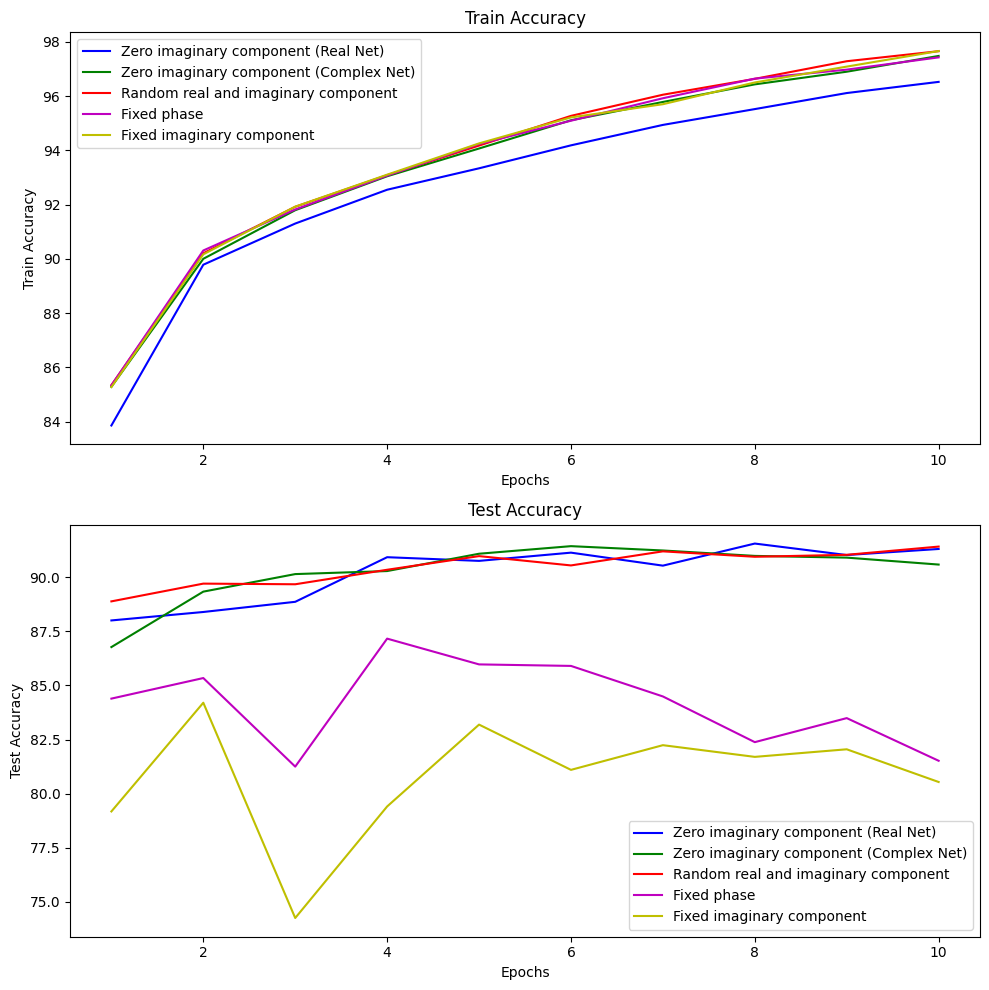

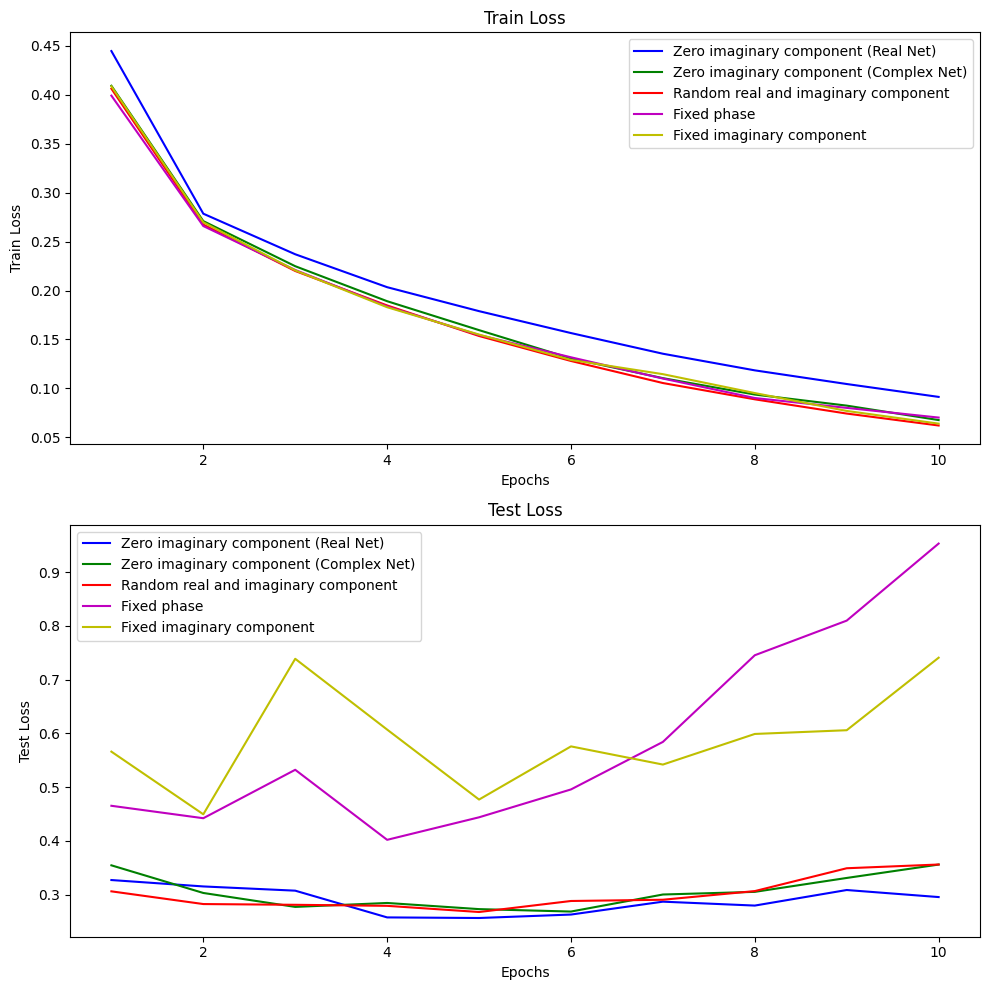

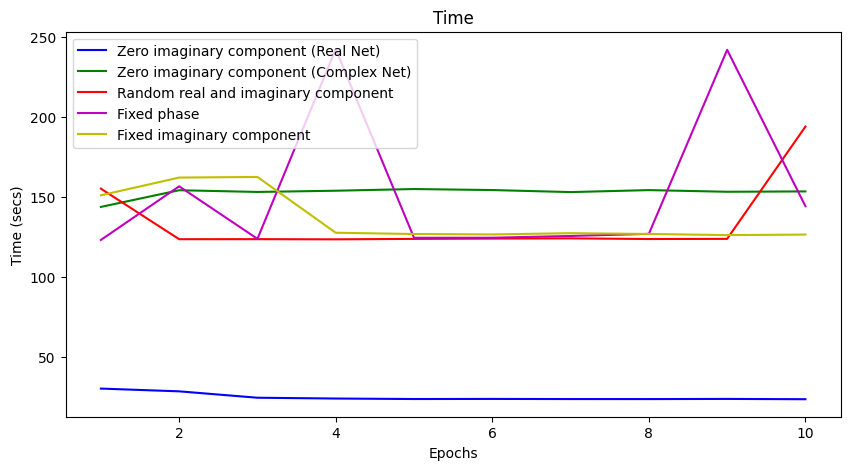

In [20]:
# Data for the four scenarios
data = {
    "Zero imaginary component (Real Net)": metrics_dict_e1,
    "Zero imaginary component (Complex Net)": metrics_dict_e2,
    "Random real and imaginary component": metrics_dict_e3,
    "Fixed phase": metrics_dict_e4,
    "Fixed imaginary component": metrics_dict_e5
}

# Data for plotting
epochs = range(1, 11)
colors = ['b', 'g', 'r', 'm', 'y']
scenarios = list(data.keys())

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])

axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Accuracy")
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])

axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Loss")
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

axes[1].set_title("Test Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for i, scenario in enumerate(scenarios):
    axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
axes.set_title("Time")
axes.set_xlabel("Epochs")
axes.set_ylabel("Time (secs)")
axes.legend()


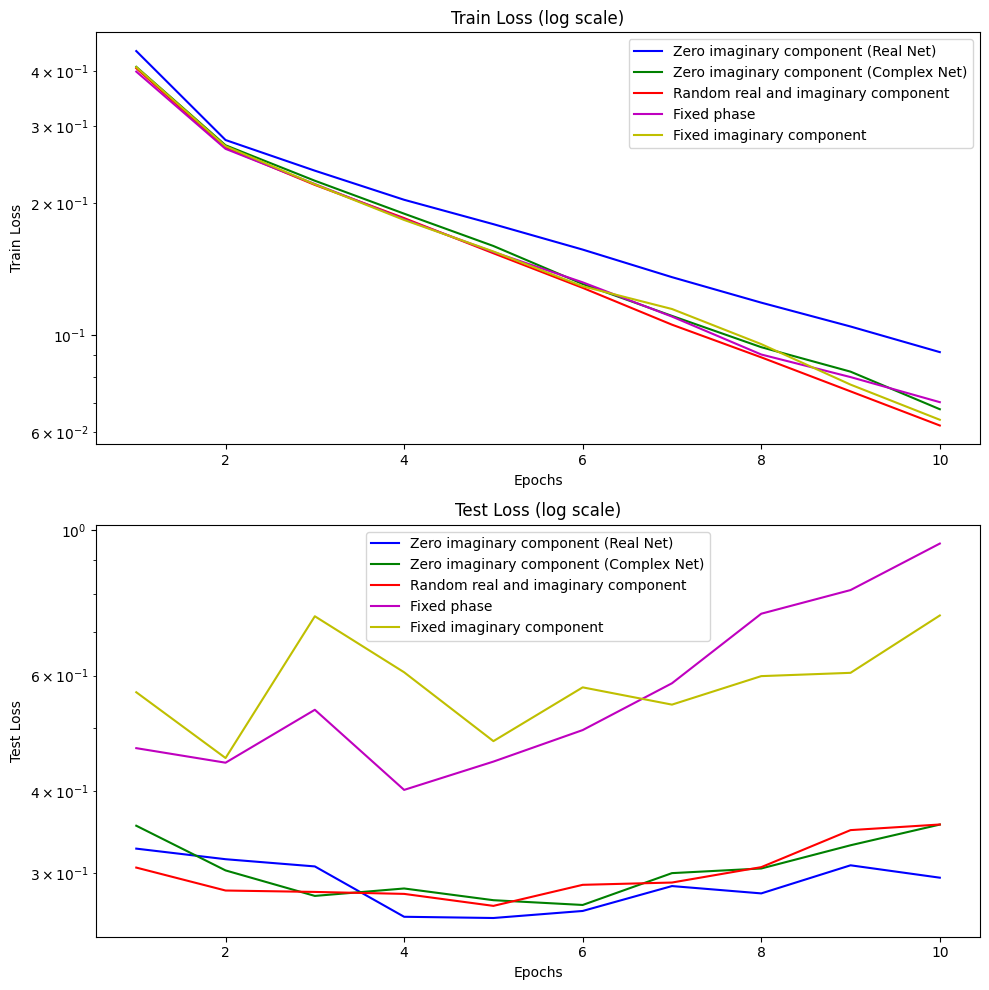

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

axes[0].set_title("Train Loss (log scale)")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Loss")
axes[0].set_yscale('log')
axes[0].legend()

for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

axes[1].set_title("Test Loss (log scale)")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()